In [1]:
import numpy as np
import torch as th
from matplotlib import pyplot as plt
from time import time as get_time
# from utilities import *
from force_engine import * 
# from decay_fourier import *
# from GLE_fitting import AIGLE
from AIGLE.decay_fourier import *
from AIGLE.fit import AIGLE
from AIGLE.utilities import *

np.set_printoptions(precision=8)
dev = 'cuda' if th.cuda.is_available() else 'cpu'


# load FES through Fourier fitting

In [26]:
## load through Fourier fitting
# load free energy parameters
fes_coef_cos = np.load('alanine_depeptide/GLE_data/fes_fourier_coef_cos.npy' )
fes_coef_sin = np.load('alanine_depeptide/GLE_data/fes_fourier_coef_sin.npy' )
fes_freq = np.load('alanine_depeptide/GLE_data/fes_fourier_freq.npy' )

fes_coef_cos = np2th(fes_coef_cos)
fes_coef_sin = np2th(fes_coef_sin)
fes_freq = np2th(fes_freq)

def get_fes_func(cosw_coef, sinw_coef, kxy):
    def fes_func(rxy):
        return fourier_nd_potential( cosw_coef, sinw_coef, kxy, rxy )
    return fes_func

def get_force_func(cosw_coef, sinw_coef, kxy):
    def force_func(rxy):
        return fourier_nd_force( cosw_coef, sinw_coef, kxy, rxy )
    return force_func

calc_fes = get_fes_func(fes_coef_cos, fes_coef_sin, fes_freq)  ## in unit of kbT
calc_force = get_force_func(fes_coef_cos, fes_coef_sin, fes_freq)  # in unit of kbT/nm


# load FES through intepolation


In [2]:
kbT2kjmol = 2.479
free_energy = np.load('./alanine_depeptide/free_energy.npy') #kJ/mol
free_energy -= free_energy.min()
free_energy /= kbT2kjmol  # in unit of kbT
free_energy = free_energy.T

def interpolate(m, shift):
    shift_x, shift_y = shift
    y0 = (1-shift_x) * m[0, 0] + shift_x * m[1,0]
    y1 = (1-shift_x) * m[0, 1] + shift_x * m[1,1]
    result = (1-shift_y)* y0 + shift_y * y1
    return result
 
def get_force_func(free_energy, dx, dy):
    fes_gradx = ( np.roll(free_energy[:-1,:-1],-1,0) - np.roll(free_energy[:-1,:-1], 1, 0 )) / 2 / dx
    fes_grady = ( np.roll(free_energy[:-1,:-1],-1,1) - np.roll(free_energy[:-1,:-1], 1, 1 )) / 2 / dy    
    nx, ny = fes_gradx.shape
    def interpolated_force(phi_psi):
        rxy = (phi_psi+np.pi) / (2*np.pi)
        rxy = rxy - np.floor(rxy)
        rxy = rxy 
        lx = rxy[0] * nx
        ly = rxy[1] * ny   ## relative location between 0 and nx/ny

        base_idx_x = int(np.floor(lx)) % nx 
        base_idx_y = int(np.floor(ly)) % ny
        next_idx_x = (base_idx_x+1) % nx
        next_idx_y = (base_idx_y+1) % ny

        m = np.array([
            [fes_gradx[base_idx_x, base_idx_y], fes_gradx[base_idx_x, next_idx_y]],
            [fes_gradx[next_idx_x, base_idx_y], fes_gradx[next_idx_x, next_idx_y]]
        ])

        grad_x = interpolate(m, shift=[lx - base_idx_x, ly - base_idx_y])

        m = np.array([
            [fes_grady[base_idx_x, base_idx_y], fes_grady[base_idx_x, next_idx_y]],
            [fes_grady[next_idx_x, base_idx_y], fes_grady[next_idx_x, next_idx_y]]
        ])

        grad_y = interpolate(m, shift=[lx - base_idx_x, ly - base_idx_y])
        force = - np.array([grad_x, grad_y])
        return force
    return interpolated_force

dx = 2 * np.pi / (free_energy.shape[0]-1)
dy = 2 * np.pi / (free_energy.shape[1]-1)

def get_force_func_torch(force_func_np):
    def force_func(rxy):
        if rxy.flatten().shape[0] == 2:
            force = force_func_np(th2np(rxy).flatten())
            return np2th(force).reshape(rxy.shape)
        else:
            _rxy = th2np(rxy)
            nframes = _rxy.shape[0]
            force = np.zeros((nframes, 2))
            for idx in range(nframes):
                force[idx] += force_func_np(_rxy[idx]) 
            return np2th(force)
    return force_func
    
force_func_np = get_force_func(free_energy, dx, dy)
calc_force = get_force_func_torch(force_func_np)

## load CV trajectories, get force trajectories

before transformation, cross vv= [[ 82.37789  -21.477077]
 [-21.477077  61.27909 ]]
after transformation, cross vv= [[4.790037e+01 8.812505e-07]
 [8.812505e-07 9.575662e+01]]
data duration: 20.00ns
eigM: tensor([[-0.5287, -0.8488],
        [-0.8488,  0.5287]])


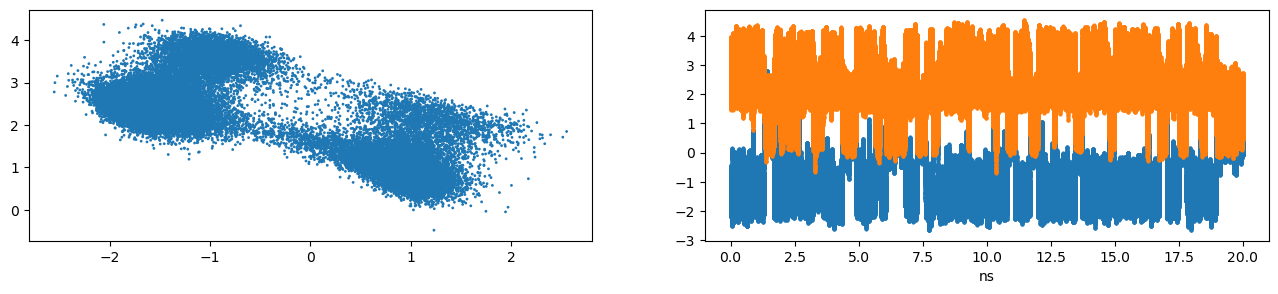

In [3]:
# load CV trajectory data: position, velocity and acceleration
dt = 0.004    #ps
cv_x = np.load('alanine_depeptide/data/traj_4fs.npy')[:10000000]
ndim = cv_x.shape[1]

cv_x = np2th(cv_x) 
cv_v = (cv_x[1:] - cv_x[:-1])/dt # nm/ns

cv_a = (cv_v[1:] - cv_v[:-1])/dt # nm/ns^2
cv_x = cv_x[1:-1] 
cv_v_lagged = cv_v[:-1] * 1.0
cv_v = (cv_v[1:] + cv_v[:-1])/2

nframes =   cv_x.shape[0]
## now do the transformation
cross_vv = (cv_v[:,:,None] * cv_v[:,None,:]).mean(0)
print('before transformation, cross vv=', th2np(cross_vv))
eig, eigM = th.linalg.eigh(cross_vv)

cv_x = cv_x @ eigM
cv_v = cv_v @ eigM
cv_a = cv_a @ eigM
cross_vv = (cv_v[:,:,None] * cv_v[:,None,:]).mean(0)
print('after transformation, cross vv=', th2np(cross_vv))


# fig,ax = plt.subplots(figsize=(8,2))
# plt.plot(dt * np.arange(nframes) / 1000, th2np(cv_x[:nframes,1]), marker='o', markersize=1.5)
# plt.xlabel('t [us]')

print('data duration: {:.2f}ns'.format(cv_v.shape[0]*dt/1e3))

fig, ax = plt.subplots(1,2, figsize=(16,3))
ax[0].scatter(th2np(cv_x[::100,0]) , th2np(cv_x[::100,1]), np.ones_like(th2np(cv_x[::100,0])) )
# ax[0].set_xlim(-np.pi*1.2,np.pi*1.2)
# ax[0].set_ylim(-np.pi,np.pi*1.5)

_nn = nframes 
ax[1].plot(np.arange(_nn)*dt/1000, th2np((cv_x )[:_nn,0]), marker='o', markersize=2)
ax[1].plot(np.arange(_nn)*dt/1000, th2np((cv_x )[:_nn,1]), marker='o', markersize=2)
ax[1].set_xlabel('ns')
 
print('eigM:',eigM)

v2avg=tensor([47.9004, 95.7566]), mass=tensor([0.0209, 0.0104])
max(x)=tensor([2.8145, 4.5448]), min(x)=tensor([-2.6643, -0.6956])
CV1  q: mean=-1.5568,std=1050.24
CV2  q: mean=-2.9473,std=1659.17


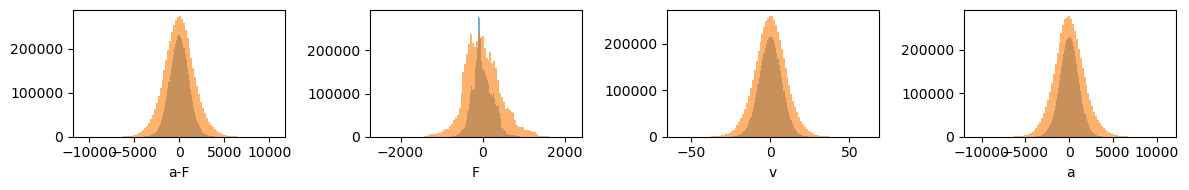

In [4]:
## calculate mass
temp = 300 # K
kbT = 1 # in unit ofabs kbT
v2avg = (cv_v**2).mean(0)  # (nm/ns)**2
mass = kbT / v2avg  ## kbT / (nm/ns)**2
print('v2avg={}, mass={}'.format(v2avg, mass))
## calculate force
cv_f = calc_force(cv_x@eigM.T)@eigM / mass[None,:]
cv_q = cv_a - cv_f

alpha=0.6
fig,ax = plt.subplots(1,4,figsize=(12,2))
for i in range(ndim):
    ax[0].hist(th2np(cv_q[:,i]), 100, alpha=alpha)
    ax[1].hist(th2np(cv_f[:,i]), 100, alpha=alpha)
    ax[2].hist(th2np(cv_v[:,i]), 100, alpha=alpha)
    ax[3].hist(th2np(cv_a[:,i]), 100, alpha=alpha)


ax[0].set_xlabel('a-F')
ax[1].set_xlabel('F')
ax[2].set_xlabel('v')
ax[3].set_xlabel('a')
plt.tight_layout()

print( 'max(x)={}, min(x)={}'.format(cv_x.max(0)[0],cv_x.min(0)[0]))
print('CV1  q: mean={:.4f},std={:.2f}'.format(cv_q[:,0].mean(), cv_q[:,0].std()))
print('CV2  q: mean={:.4f},std={:.2f}'.format(cv_q[:,1].mean(), cv_q[:,1].std()))


## diffusion analysis

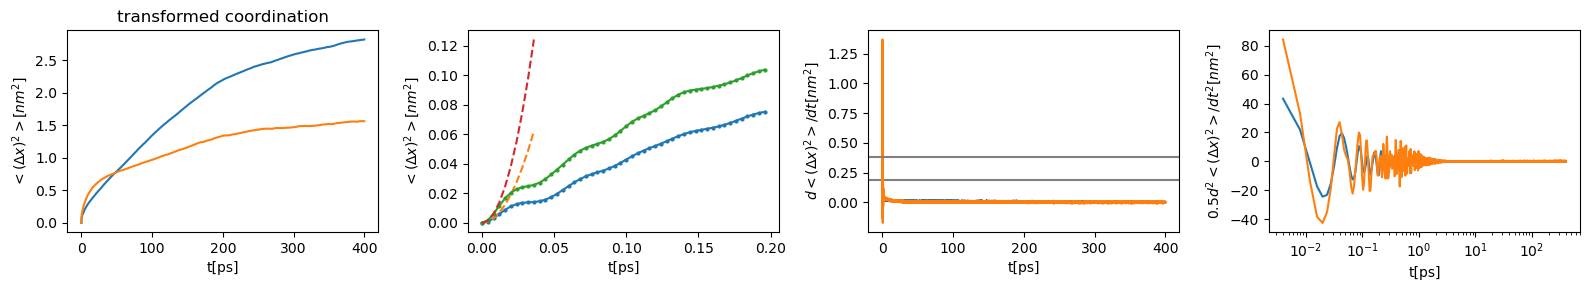

In [65]:
r2 = [th.zeros_like(cv_x[0])]
n=100000
for idx in range(1,n):
    r2.append(((cv_x[idx:] - cv_x[:-idx])**2).mean(0))
r2 = th.stack(r2,0)

r2 = th2np(r2)
dr2 = (r2[1:]-r2[:-1])/dt
ddr2 = (dr2[1:]-dr2[:-1])/dt

## plot
fig, ax = plt.subplots(1,4, figsize=(16,3))
for idx in range(ndim):
    ax[0].plot(np.arange(n)*dt, r2[:,idx])
    ax[0].set_xlabel('t[ps]')
    ax[0].set_ylabel('$<(\Delta x)^2>$[$nm^2$]')
    nn = 50
    ax[1].plot(np.arange(nn)*dt, np.array(r2)[:nn,idx], marker='o', markersize=2)
    ax[1].plot(np.arange(10)*dt, th2np(v2avg)[idx] * (np.arange(10)*dt)**2, linestyle='dashed' )
    ax[1].set_xlabel('t[ps]')
    ax[1].set_ylabel('$<(\Delta x)^2>$[$nm^2$]')


    ax[2].plot(np.arange(n-1)*dt + 0.5*dt ,dr2[:,idx])
    ax[2].axhline(th2np(v2avg)[idx]*dt, color='grey')
    ax[2].set_xlabel('t[ps]')
    ax[2].set_ylabel('$d<(\Delta x)^2>/dt$[$nm^2$]')

    ax[3].semilogx(np.arange(n-2)*dt + dt ,ddr2[:,idx]/2)
    ax[3].set_xlabel('t[ps]')
    ax[3].set_ylabel('$0.5d^2<(\Delta x)^2>/dt^2$[$nm^2$]')
ax[0].set_title('transformed coordination')
plt.tight_layout()



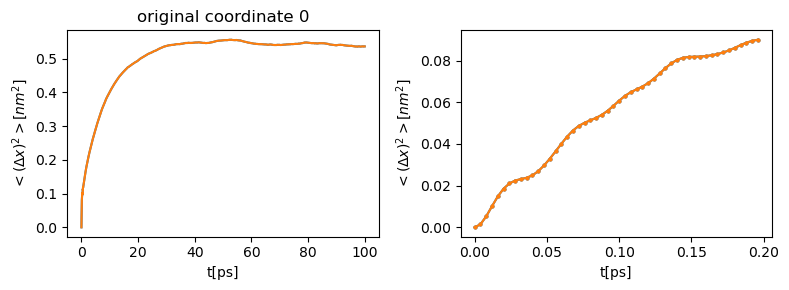

In [66]:
cv_main = (cv_x @ eigM.T)[:,0]

r2_main = [th.zeros_like(cv_main[0])]
n=25000
for idx in range(1,n):
    r2_main.append(((cv_main[idx:] - cv_main[:-idx])**2).mean())
r2_main = th.stack(r2_main,0)
r2_main = th2np(r2_main)
## plot
fig, ax = plt.subplots(1,2, figsize=(8,3))
for idx in range(ndim):
    ax[0].plot(np.arange(n)*dt, r2_main )
    ax[0].set_xlabel('t[ps]')
    ax[0].set_ylabel('$<(\Delta x)^2>$[$nm^2$]')
    nn = 50
    ax[1].plot(np.arange(nn)*dt, np.array(r2_main)[:nn], marker='o', markersize=2)
    ax[1].set_xlabel('t[ps]')
    ax[1].set_ylabel('$<(\Delta x)^2>$[$nm^2$]')

ax[0].set_title('original coordinate 0')
plt.tight_layout()


## calculate correlation <q(t)v(0)> and <v(t)v(0)>

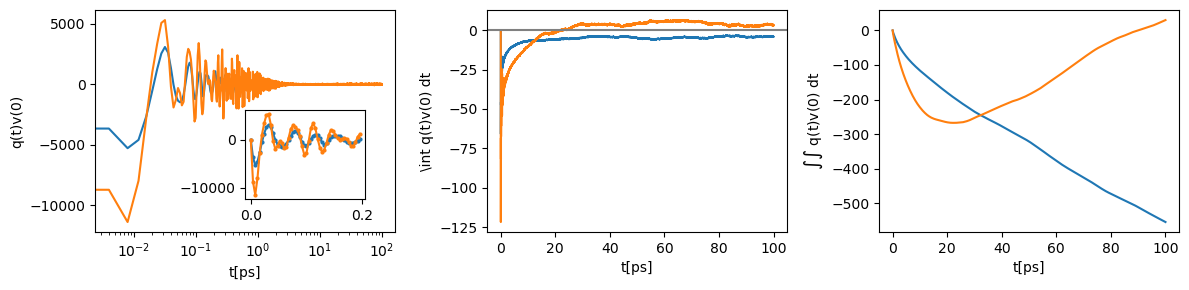

In [5]:
## force, velocity correlation
ncorr = 25000
corr_t = np.arange(ncorr) * dt  # ns
corr_qtv0 = Corr_t(cv_v, cv_q, ncorr)
int1_qtv0 = th.cumsum( (corr_qtv0[1:]+corr_qtv0[:-1])/2, 0) * dt
int1_qtv0 = th.cat([th.zeros_like(int1_qtv0[0]).reshape(1,2), int1_qtv0], 0)
int2_qtv0 = th.cumsum( (int1_qtv0[1:]+int1_qtv0[:-1])/2, 0) * dt
int2_qtv0 = th.cat([th.zeros_like(int2_qtv0[0]).reshape(1,2), int2_qtv0], 0)

fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].semilogx(corr_t, th2np(corr_qtv0)[:,0])
ax[0].semilogx(corr_t, th2np(corr_qtv0)[:,1])
axins = ax[0].inset_axes([0.5, 0.15, 0.4, 0.4])
axins.plot(corr_t[:50]  , th2np(corr_qtv0)[:50,0], marker='o', markersize=2)
axins.plot(corr_t[:50]  , th2np(corr_qtv0)[:50,1], marker='o', markersize=2)

ax[0].set_xlabel('t[ps]')
ax[0].set_ylabel('q(t)v(0)')


ax[1].plot(corr_t, th2np(int1_qtv0)[:,0])
ax[1].plot(corr_t, th2np(int1_qtv0)[:,1])
ax[1].axhline(0, color='grey')
ax[1].set_xlabel('t[ps]')
ax[1].set_ylabel('\int q(t)v(0) dt')

ax[2].plot(corr_t, th2np(int2_qtv0)[:,0])
ax[2].plot(corr_t, th2np(int2_qtv0)[:,1])
ax[2].set_xlabel('t[ps]')
ax[2].set_ylabel('$\int \int$ q(t)v(0) dt')


plt.tight_layout()

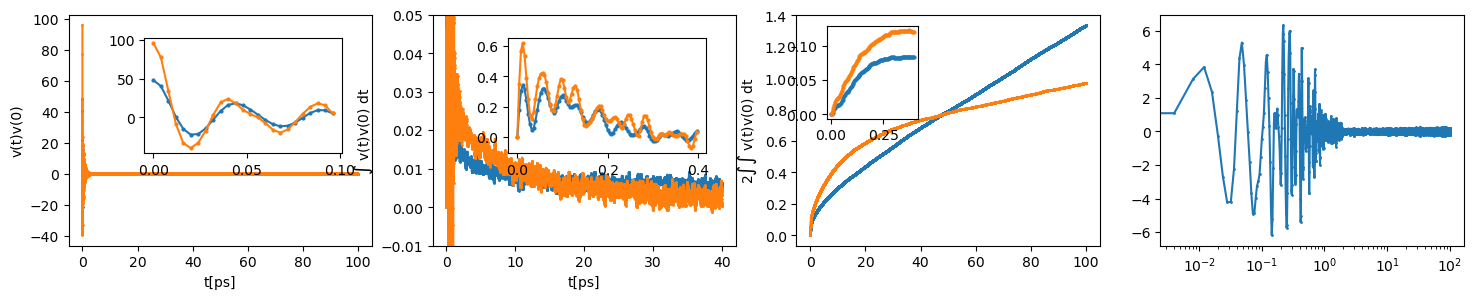

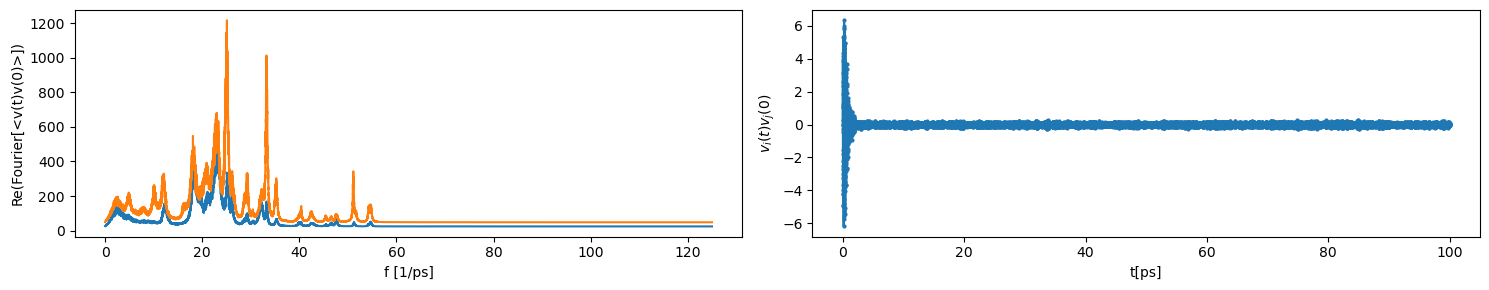

In [6]:
## velocity auto-correlation
corr_vtv0 = Corr_t(cv_v, cv_v, ncorr)
cross_vtv0 = Corr_t(cv_v[:,0], cv_v[:,1], ncorr)
int1_vtv0 = th.cumsum( (corr_vtv0[1:]+corr_vtv0[:-1])/2, 0) * dt
int1_vtv0 = th.cat([th.zeros_like(int1_vtv0[0]).reshape(1,2), int1_vtv0], 0)
int2_vtv0 = th.cumsum( (int1_vtv0[1:]+int1_vtv0[:-1])/2, 0) * dt
int2_vtv0 = th.cat([th.zeros_like(int2_vtv0[0]).reshape(1,2), int2_vtv0], 0)


fig, ax = plt.subplots(1,4, figsize=(18,3))
fig1, ax1 = plt.subplots(1,2, figsize=(15,3))

axins0 = ax[0].inset_axes([0.25, 0.4, 0.65, 0.5])
axins1 = ax[1].inset_axes([0.25, 0.4, 0.65, 0.5])
axins2 = ax[2].inset_axes([0.1, 0.55, 0.3, 0.4])
for i in range(ndim):
    ax[0].plot(corr_t , th2np(corr_vtv0)[:,i] , marker='o', markersize=1)
    axins0.plot(corr_t[:25]  , th2np(corr_vtv0)[:25,i], marker='o', markersize=2)

    ax[1].plot(corr_t[:10000], th2np(int1_vtv0[:10000,i]), marker='o', markersize=1)
    axins1.plot(corr_t[:100]  , th2np(int1_vtv0[:,i])[:100], marker='o', markersize=2)
    ax[1].set_ylim(-0.01, 0.05)
    
    ax[2].plot(corr_t, 2*th2np(int2_vtv0[:,i]), marker='o', markersize=1)
    axins2.plot(corr_t[:100]  , 2*th2np(int2_vtv0[:,i])[:100], marker='o', markersize=2)
    
    spectrum = np.fft.rfft(th2np(corr_vtv0[:,i]))
    spectrum_freq = np.arange(spectrum.shape[0]) / (ncorr*dt)
    ax1[0].plot(spectrum_freq, spectrum.real)
ax[3].semilogx(corr_t , th2np(cross_vtv0), marker='o', markersize=1)
ax1[1].plot(corr_t, th2np(cross_vtv0), marker='o', markersize=2)
# ax[3].plot(corr_t, np.cumsum(cross_vtv0), marker='o', markersize=2)
    

ax[0].set_xlabel('t[ps]')
ax[1].set_xlabel('t[ps]')
ax[0].set_ylabel('v(t)v(0)')
ax[1].set_ylabel('$\int$ v(t)v(0) dt')
ax[2].set_ylabel('2$\int\int$ v(t)v(0) dt')


ax1[0].set_xlabel('f [1/ps]')
ax1[0].set_ylabel('Re(Fourier[<v(t)v(0)>])')
ax1[1].set_xlabel('t[ps]')
ax1[1].set_ylabel('$v_i(t)v_j(0)$')

plt.tight_layout()

## calculate memory kernel

### inverse <q(t)v(0)>=$\int$ K(s)<v(t)v(0)>ds and fit the results

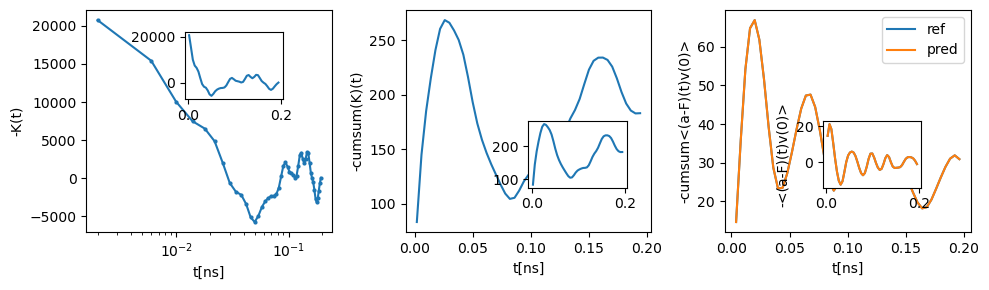

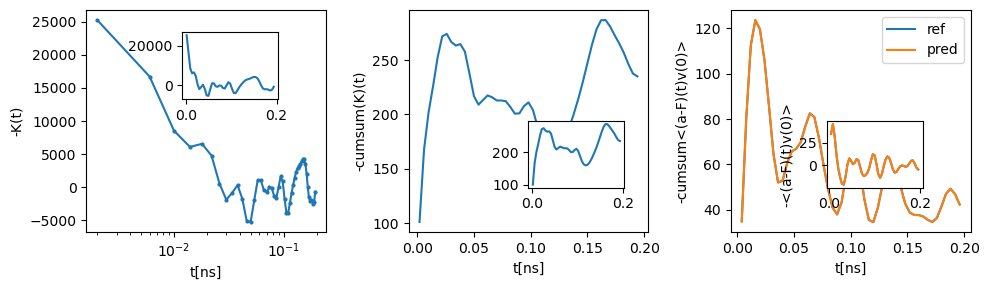

In [8]:
ref_mem_kernel_list = []
kernel_length = int(0.2/dt)
for idx in range(ndim):
    ref_mem_kernel, fit_t, fit_A, fit_b = get_exact_memory_kernel(corr_vtv0[:,idx], corr_qtv0[:,idx], kernel_length=kernel_length, dt=dt)
    ref_mem_kernel_list.append(ref_mem_kernel)
    
    ###################### plotting
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    ax[0].semilogx(th2np(fit_t)[:20000], - th2np(ref_mem_kernel)[:20000], marker='o', markersize=2)
    # ax[0].plot(fit_t[100:], -(th2np(ref_mem_kernel[100:])))
    ax[0].set_xlabel('t[ns]')
    ax[0].set_ylabel('-K(t)')
    axins = ax[0].inset_axes([0.4, 0.6, 0.4, 0.3])
    axins.plot(th2np(fit_t)[:250], -th2np(ref_mem_kernel)[:250])

    cumsum_ref_mem_kernel = np.cumsum(th2np(ref_mem_kernel)) * dt
    ax[1].plot(th2np(fit_t), -cumsum_ref_mem_kernel)
    ax[1].set_xlabel('t[ns]')
    ax[1].set_ylabel('-cumsum(K)(t)')
    axins = ax[1].inset_axes([0.5, 0.2, 0.4, 0.3])
    axins.plot(th2np(fit_t)[:100], -cumsum_ref_mem_kernel[:100])

    ax[2].plot(th2np(fit_t) +0.5*dt, -np.cumsum(th2np(fit_b))*dt , label='ref')
    ax[2].plot(th2np(fit_t) +0.5*dt, -np.cumsum(th2np(fit_A@ref_mem_kernel))*dt , label='pred')
    ax[2].legend()
    ax[2].set_xlabel('t[ns]')
    ax[2].set_ylabel('-cumsum<(a-F)(t)v(0)>')
    axins = ax[2].inset_axes([0.4, 0.2, 0.4, 0.3])
    axins.plot(th2np(fit_t)[:50] +0.5*dt, -th2np(fit_b)[:50]*dt)
    axins.plot(th2np(fit_t)[:50] +0.5*dt, -th2np(fit_A@ref_mem_kernel)[:50]*dt)

    axins.set_ylabel('-<(a-F)(t)v(0)>')

    plt.tight_layout()
 

iter=0, loss=41911.96484375 tau=[  0.501    5.01    50.1001 501.0009]
iter=300, loss=350.0688781738281 tau=[5.1333e-01 5.1303e+00 5.1113e+01 5.2369e+02]
iter=600, loss=336.12835693359375 tau=[5.1888e-01 5.1821e+00 5.1488e+01 5.2848e+02]
iter=900, loss=330.1828918457031 tau=[5.3021e-01 5.2843e+00 5.2186e+01 5.3149e+02]
iter=1200, loss=320.8440246582031 tau=[  0.5539   5.4846  53.3484 534.7327]
iter=1500, loss=308.3820495605469 tau=[  0.6042   5.8547  54.9622 538.8536]
iter=1800, loss=297.1116943359375 tau=[  0.7055   6.4061  56.2594 544.408 ]
iter=2100, loss=288.9301452636719 tau=[  0.9242   7.0408  56.1686 550.9374]
iter=2400, loss=279.67352294921875 tau=[  1.6045   7.6387  54.509  557.2411]
iter=2700, loss=261.1866760253906 tau=[  3.1683   7.382   51.301  562.8212]
iter=3000, loss=244.98983764648438 tau=[  3.2143   6.3767  49.2588 567.0183]
iter=3300, loss=232.96376037597656 tau=[  2.7661   5.5813  48.6438 569.7427]
iter=3600, loss=223.2293701171875 tau=[  2.3289   5.078   48.4659 572

Text(0, 0.5, 'tau')

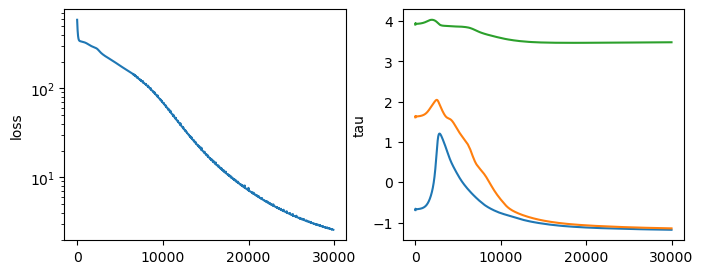

In [13]:
### initialize GLE fitting
niter = 30000
taus = th.tensor([ 0.5, 5, 50, 500], dtype=th.float, requires_grad=True, device=dev)
aigle = AIGLE(dt, ndim, temp, v2avg, taus).to(device=dev)
aigle.init_optimizer(lr_coef=0.0002, lr_tau=0.002, gamma=0.99)

### set up the learning target and the time grid
ref_mem_kernel = th.stack(ref_mem_kernel_list)
ref_mem_kernel_tgrid =  np2th( np.arange(ref_mem_kernel.shape[1]) + 0.5 ) * dt

### train
loss_curve, logtau_curve = aigle.train(niter, ref_mem_kernel_tgrid, ref_mem_kernel, verbose=True)
aigle.save('fip35/GLE_data/cv_tau4.json'.format(idx))

### finalize results
pred_mem_kernel = aigle.get_mem_kernel(ref_mem_kernel_tgrid)
pred_mem_kernel_cumsum = th.cumsum(pred_mem_kernel, 1)
ref_mem_kernel_cumsum_tgrid = ref_mem_kernel_tgrid + 0.5 * dt
ref_mem_kernel_cumsum = th.cumsum(ref_mem_kernel, 1)

#### plot loss curve
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].semilogy(loss_curve[100:])
ax[0].set_ylabel('loss')
ax[1].plot(logtau_curve[:,0])
ax[1].plot(logtau_curve[:,1])
ax[1].plot(logtau_curve[:,2])
ax[1].set_ylabel('tau')



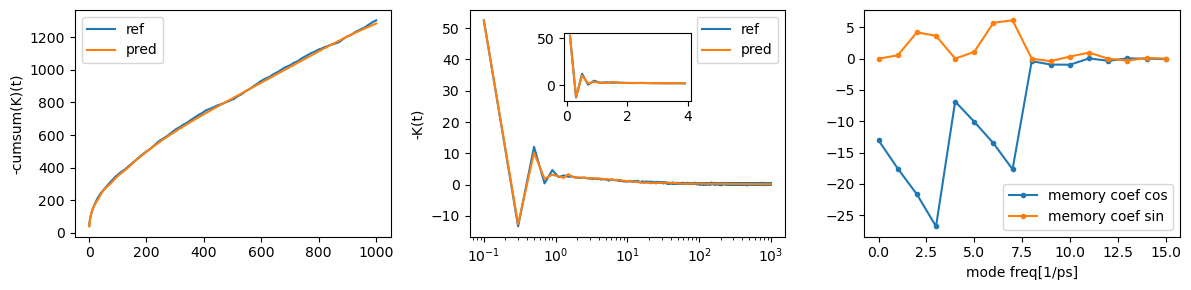

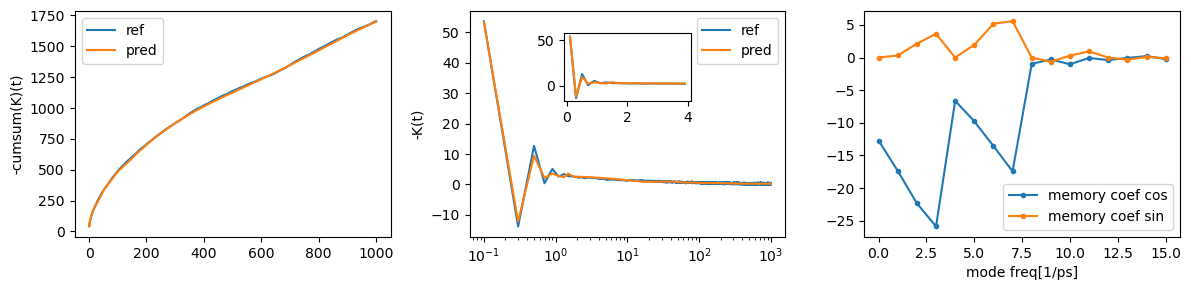

In [14]:
## plot the results
for idx in range(ndim):
    #### plot predicted memory kernel versus reference memory kernel
    fig, ax = plt.subplots(1,3, figsize=(12,3))

    ax[0].plot(th2np(ref_mem_kernel_cumsum_tgrid), th2np(-ref_mem_kernel_cumsum[idx]), label='ref')
    ax[0].plot(th2np(ref_mem_kernel_cumsum_tgrid), th2np(-pred_mem_kernel_cumsum[idx]), label='pred')
    ax[0].legend()
    ax[0].set_ylabel('-cumsum(K)(t)')

    ax[1].semilogx(th2np(ref_mem_kernel_tgrid), -th2np(ref_mem_kernel[idx]), label='ref')
    ax[1].semilogx(th2np(ref_mem_kernel_tgrid), -th2np(pred_mem_kernel[idx]), label='pred')
    ax[1].legend()
    ax[1].set_ylabel('-K(t)')
    axins = ax[1].inset_axes([0.3, 0.6, 0.4, 0.3])
    axins.plot(th2np(ref_mem_kernel_tgrid[:20]), -th2np(ref_mem_kernel[idx])[:20])
    axins.plot(th2np(ref_mem_kernel_tgrid[:20]), -th2np(pred_mem_kernel[idx])[:20])


    ax[2].plot( th2np(aigle.mem_coef_cos[idx]), label='memory coef cos', marker='o', markersize=3)
    ax[2].plot( th2np(aigle.mem_coef_sin[idx]), label='memory coef sin', marker='o', markersize=3)
    ax[2].legend()
    ax[2].set_xlabel('mode freq[1/ps]')
    plt.tight_layout()

### inverse $\int$ <q(t)v(0)>dt=$\int\int$ K(s)<v(t)v(0)>ds dt

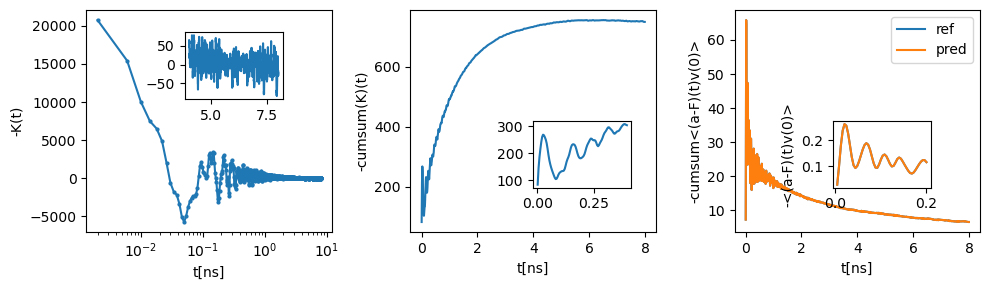

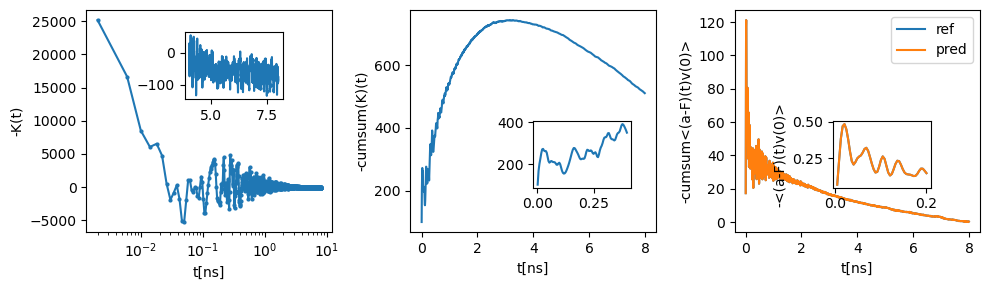

In [136]:
ref_mem_kernel_list = []

qv_cumsum = th.cumsum( (corr_qtv0[1:]+corr_qtv0[:-1])/2, 0) * dt
vv_cumsum = th.cumsum( (corr_vtv0[1:]+corr_vtv0[:-1])/2, 0) * dt
vv_cumsum = th.cat([th.zeros_like(vv_cumsum[0]).reshape(1,2), vv_cumsum], 0)
vv_cumsum_halfgrid = (vv_cumsum[1:]+vv_cumsum[:-1])/2
ref_mem_kernel = []
nk =  ncorr - 2 
for idx in range(ndim):
    mat_cvv = np2th(np.zeros((nk, nk)))
    for ii in range(mat_cvv.shape[0]):
        mat_cvv[ii, :ii+1] = th.flip(vv_cumsum_halfgrid[ :ii+1, idx ], [0])
    fit_b = qv_cumsum[:nk, idx]
    fit_A = mat_cvv * dt
    fit_t = np2th(dt*(np.arange(nk)+0.5))
    lstsq_results = th.linalg.lstsq(fit_A, fit_b, rcond=None)
    ref_mem_kernel = lstsq_results.solution
    ref_mem_kernel_list.append(ref_mem_kernel)

# ###################### plotting
# for idx in range(ndim):
#     ref_mem_kernel = ref_mem_kernel_list[idx]
#     mat_cvv = np2th(np.zeros((nk, nk)))
#     for ii in range(mat_cvv.shape[0]):
#         mat_cvv[ii, :ii+1] = th.flip(vv_cumsum_halfgrid[ :ii+1, idx ], [0])
#     fit_b = qv_cumsum[:nk, idx]
#     fit_A = mat_cvv * dt
#     fit_t = np2th(dt*(np.arange(nk)+0.5))
    
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    ax[0].semilogx(th2np(fit_t)[:20000], - th2np(ref_mem_kernel)[:20000], marker='o', markersize=2)
    # ax[0].plot(fit_t[100:], -(th2np(ref_mem_kernel[100:])))
    ax[0].set_xlabel('t[ns]')
    ax[0].set_ylabel('-K(t)')
    axins = ax[0].inset_axes([0.4, 0.6, 0.4, 0.3])
    axins.plot(th2np(fit_t)[1000:], -th2np(ref_mem_kernel)[1000:])

    cumsum_ref_mem_kernel = np.cumsum(th2np(ref_mem_kernel)) * dt
    ax[1].plot(th2np(fit_t), -cumsum_ref_mem_kernel)
    ax[1].set_xlabel('t[ns]')
    ax[1].set_ylabel('-cumsum(K)(t)')
    axins = ax[1].inset_axes([0.5, 0.2, 0.4, 0.3])
    axins.plot(th2np(fit_t)[:100], -cumsum_ref_mem_kernel[:100])

    ax[2].plot(th2np(fit_t) +0.5*dt, - (th2np(fit_b))  , label='ref')
    ax[2].plot(th2np(fit_t) +0.5*dt, - (th2np(fit_A@ref_mem_kernel))  , label='pred')
    ax[2].legend()
    ax[2].set_xlabel('t[ns]')
    ax[2].set_ylabel('-cumsum<(a-F)(t)v(0)>')
    axins = ax[2].inset_axes([0.4, 0.2, 0.4, 0.3])
    axins.plot(th2np(fit_t)[:50] +0.5*dt, -th2np(fit_b)[:50]*dt)
    axins.plot(th2np(fit_t)[:50] +0.5*dt, -th2np(fit_A@ref_mem_kernel)[:50]*dt)

    axins.set_ylabel('-<(a-F)(t)v(0)>')

    plt.tight_layout()
 

### fitting   <q(t)v(0)>dt=$ \int$ K(s)<v(t)v(0)>ds dt

iter=0, loss=2959078.5 tau=[0.01007538 0.10096812 1.0099667  2.0198863 ]
iter=500, loss=1962689.25 tau=[0.19757931 0.23641697 0.57519084 4.861349  ]
iter=1000, loss=1305949.0 tau=[0.13873395 0.14778996 0.17274031 1.3789629 ]
iter=1500, loss=979404.8125 tau=[0.10145799 0.11822333 0.13714139 0.28091282]
iter=2000, loss=735175.5625 tau=[0.07498308 0.07643452 0.12652223 0.15228394]
iter=2500, loss=636945.4375 tau=[0.05224684 0.07317447 0.1220431  0.14361797]
iter=3000, loss=596291.6875 tau=[0.04903391 0.06907971 0.12166212 0.14039521]
iter=3500, loss=575016.5625 tau=[0.04748176 0.06842116 0.12390626 0.14093442]
iter=4000, loss=559993.6875 tau=[0.04646074 0.06928251 0.1262704  0.14187294]
iter=4500, loss=548362.5625 tau=[0.04586545 0.07039093 0.1286306  0.14300224]
iter=5000, loss=539141.0625 tau=[0.04552679 0.07134195 0.13084817 0.1442211 ]
iter=5500, loss=531889.5 tau=[0.04534077 0.07209521 0.1327745  0.14538975]
iter=6000, loss=526213.0 tau=[0.04524405 0.07263912 0.13431501 0.14638278]
i

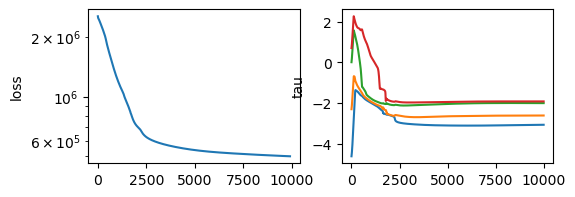

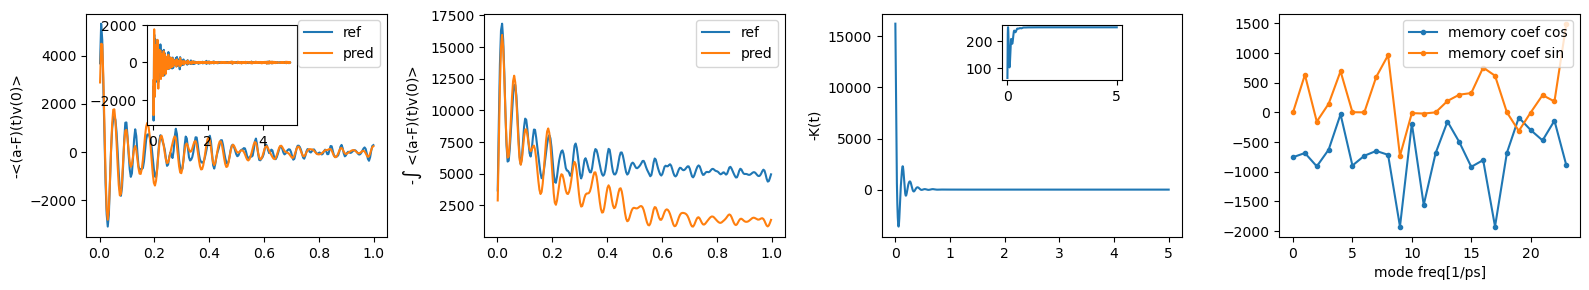

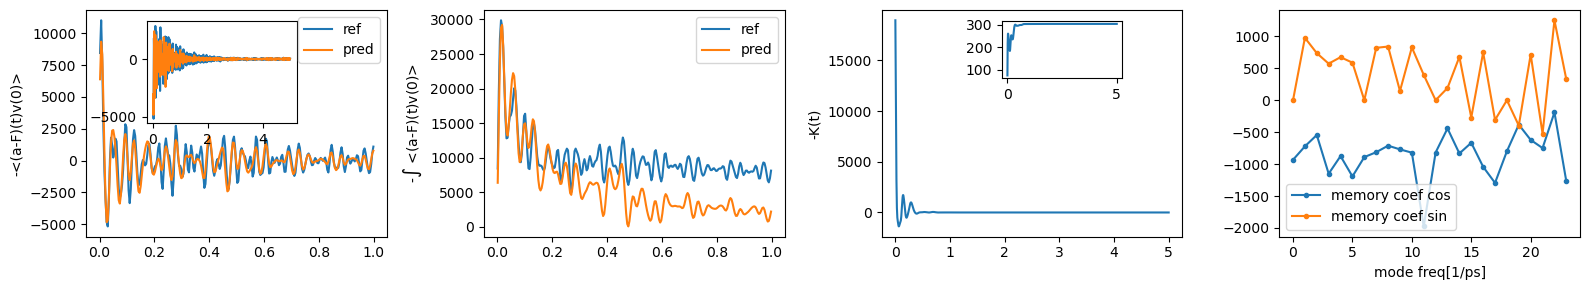

In [26]:
nk = int(1/dt)
fit_t = np2th(dt*(np.arange(nk)+0.5))
corr_vv_halfgrid = (corr_vtv0[1:]+corr_vtv0[:-1])/2

fit_b = corr_qtv0[1:nk+1]
mat_cvv = np2th(np.zeros((nk, nk, ndim)))
for idx in range(ndim):
    for ii in range(mat_cvv.shape[0]):
        mat_cvv[ii, :ii+1, idx] = th.flip(corr_vv_halfgrid[ :ii+1, idx ], [0])
fit_A = mat_cvv * dt

# fit_weight = th.exp(-fit_t / 10)
### initialize GLE fitting
niter = 10000
nfreq = 6
taus = th.tensor([ 0.01,  0.1, 1,2    ], dtype=th.float, requires_grad=True, device=dev)
# taus = th.tensor([  100,500    ], dtype=th.float, requires_grad=True, device=dev)

aigle = AIGLE(dt, ndim, temp, v2avg, taus, nfreq=nfreq).to(device=dev)
# aigle.memory_in_tau = 2
aigle.init_optimizer(lr_coef=0.2, lr_tau=0.01, gamma=0.99)
optimizer = aigle.optimizer
lossfn = th.nn.MSELoss(reduction='mean')
loss_curve = []
logtau_curve = []
for ii in range(niter):
    mem_coef_cos, mem_coef_sin, mem_kernel, mem_kernel_cumsum = aigle._compute_kernel_from_2FDT(fit_t, fit_t+0.5*dt)
    loss = 0
    for idx in range(ndim):
        ref_b = fit_b[:, idx]
        pred_b = fit_A[:,:,idx]@mem_kernel[idx]
        # loss += lossfn(ref_b[250:], pred_b[250:])
        # loss += lossfn(ref_b[:100], pred_b[:100])
        loss += lossfn(ref_b , pred_b ) 
        # loss += ((ref_b - pred_b)**2 * fit_weight).sum() / fit_weight.sum()
        # loss += th.abs(ref_b - pred_b).sum() * dt
        
    ## backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    aigle.scheduler.step()
    # aigle.log_taus.data = th.clamp(aigle.log_taus.data,  max=np.log(10) )
    ## bookkeeping
    loss_curve.append(th2np(loss))
    logtau_curve.append(th2np(aigle.log_taus).copy())
    aigle.mem_coef_cos = mem_coef_cos.detach().clone()
    aigle.mem_coef_sin = mem_coef_sin.detach().clone()    
    ## logging
    if ii % int(niter//20) ==0:
        print('iter={}, loss={} tau={}'.format(ii, th2np(loss), th2np(th.exp(aigle.log_taus))))
loss_curve=np.array(loss_curve)
logtau_curve=np.array(logtau_curve)
# aigle.save('fip35/GLE_data/cv_tau4.json')
aigle.save('alanine_depeptide/GLE_data/cv_fitddr2.json')

#### plot loss curve
fig, ax = plt.subplots(1,2, figsize=(6,2))
ax[0].semilogy(loss_curve[100:])
ax[0].set_ylabel('loss')
for idx in range(logtau_curve.shape[-1]):
    ax[1].plot(logtau_curve[:,idx])
ax[1].set_ylabel('tau')

### plot  results
nk_long = int(5/dt)
ref_mem_kernel_tgrid = np2th(dt*(np.arange(nk_long)+0.5))
pred_mem_kernel = aigle.get_mem_kernel(ref_mem_kernel_tgrid)
mat_cvv = np2th(np.zeros((nk_long, nk_long, ndim)))
for idx in range(ndim):
    for ii in range(mat_cvv.shape[0]):
        mat_cvv[ii, :ii+1, idx] = th.flip(corr_vv_halfgrid[ :ii+1, idx ], [0])
fit_A = mat_cvv * dt
fit_b = corr_qtv0[1:nk_long+1]
tgrid_long = ref_mem_kernel_tgrid #np2th(0.01*(np.arange(100000)+0.5))
pred_mem_kernel_long = aigle.get_mem_kernel(tgrid_long)

for idx in range(ndim):
    #### plot predicted memory kernel versus reference memory kernel
    fig, ax = plt.subplots(1,4, figsize=(16,3))
    
    pred_b = fit_A[:,:,idx]@pred_mem_kernel[idx]
    # ax[0].plot(th2np(ref_mem_kernel_tgrid), -th2np(fit_b[:, idx]), label='ref')
    # ax[0].plot(th2np(ref_mem_kernel_tgrid), -th2np(pred_b), label='pred')
    # ax[0].legend()
    # ax[0].set_ylabel('-cumsum<(a-F)(t)v(0)>')
    # axins = ax[0].inset_axes([0.3, 0.7, 0.4, 0.25])
    # axins.semilogx(th2np(ref_mem_kernel_tgrid ) , -th2np(fit_b[:,idx])  )
    # axins.semilogx(th2np(ref_mem_kernel_tgrid ) , -th2np(pred_b)  )
    
    
    ax[0].plot(th2np(ref_mem_kernel_tgrid[:250]), -th2np(fit_b[:250, idx]), label='ref')
    ax[0].plot(th2np(ref_mem_kernel_tgrid[:250]), -th2np(pred_b[:250]), label='pred')
    ax[0].legend()
    ax[0].set_ylabel('-<(a-F)(t)v(0)>')
    axins = ax[0].inset_axes([0.2, 0.5, 0.5, 0.45])
    axins.plot(th2np(ref_mem_kernel_tgrid[5:] ) , -th2np(fit_b[5:,idx])  )
    axins.plot(th2np(ref_mem_kernel_tgrid[5:] ) , -th2np(pred_b[5:])  )
    
    ax[1].plot(th2np(ref_mem_kernel_tgrid[:250]), -np.cumsum(th2np(fit_b[:250, idx])), label='ref')
    ax[1].plot(th2np(ref_mem_kernel_tgrid[:250]), -np.cumsum(th2np(pred_b[:250])), label='pred')
    ax[1].legend()
    ax[1].set_ylabel('-$\int$ <(a-F)(t)v(0)>')
    
    
    ax[2].plot(th2np(ref_mem_kernel_tgrid), -th2np(pred_mem_kernel[idx]) )
    ax[2].set_ylabel('-K(t)')
    axins = ax[2].inset_axes([0.4, 0.7, 0.4, 0.25])
    axins.plot(th2np(tgrid_long ), -dt*np.cumsum(th2np(pred_mem_kernel_long[idx])) )


    ax[3].plot( th2np(aigle.mem_coef_cos[idx]), label='memory coef cos', marker='o', markersize=3)
    ax[3].plot( th2np(aigle.mem_coef_sin[idx]), label='memory coef sin', marker='o', markersize=3)
    ax[3].legend()
    ax[3].set_xlabel('mode freq[1/ps]')
    plt.tight_layout()

### fitting $\int$ <q(t)v(0)>dt=$\int\int$ K(s)<v(t)v(0)>ds dt

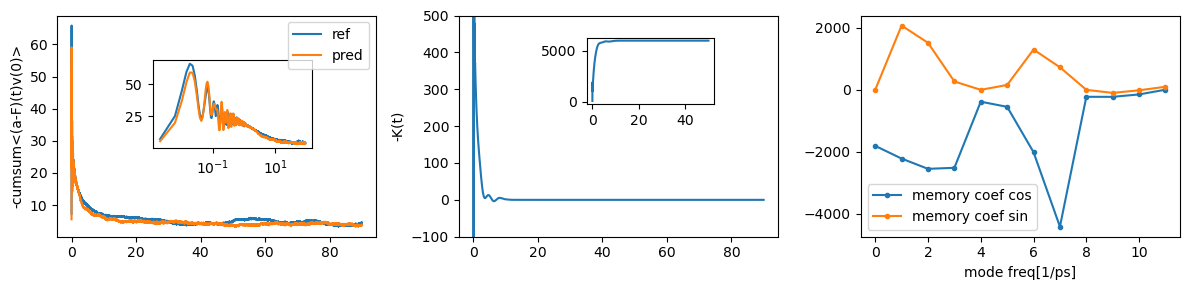

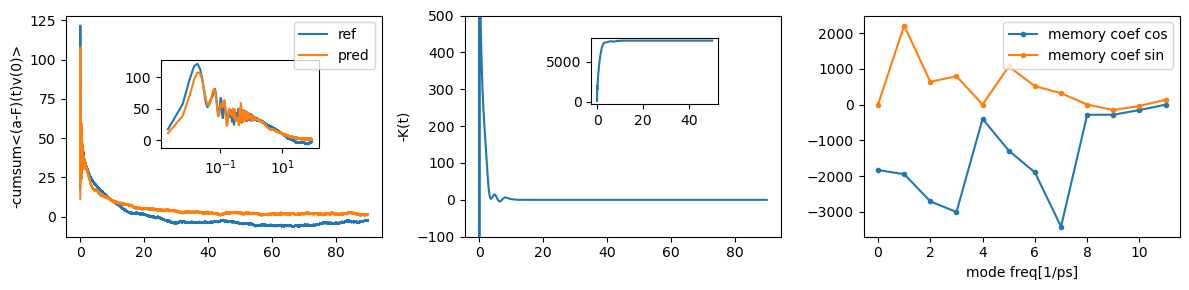

In [16]:
nk = int(2/dt)
fit_t = np2th(dt*(np.arange(nk)+0.5))
qv_cumsum = th.cumsum( (corr_qtv0[1:]+corr_qtv0[:-1])/2, 0) * dt
vv_cumsum = th.cumsum( (corr_vtv0[1:]+corr_vtv0[:-1])/2, 0) * dt
vv_cumsum = th.cat([th.zeros_like(vv_cumsum[0]).reshape(1,2), vv_cumsum], 0)
vv_cumsum_halfgrid = (vv_cumsum[1:]+vv_cumsum[:-1])/2
fit_b = qv_cumsum[:nk]
mat_cvv = np2th(np.zeros((nk, nk, ndim)))
for idx in range(ndim):
    for ii in range(mat_cvv.shape[0]):
        mat_cvv[ii, :ii+1, idx] = th.flip(vv_cumsum_halfgrid[ :ii+1, idx ], [0])
fit_A = mat_cvv * dt

# fit_weight = th.exp(-fit_t / 10)
### initialize GLE fitting
niter = 10000
nfreq = 4
taus = th.tensor([ 0.01, 0.1, 1,    ], dtype=th.float, requires_grad=True, device=dev)

aigle = AIGLE(dt, ndim, temp, v2avg, taus, nfreq=nfreq).to(device=dev)
# aigle.memory_in_tau = 2
aigle.init_optimizer(lr_coef=0.4, lr_tau=0.01, gamma=0.99)
optimizer = aigle.optimizer
lossfn = th.nn.MSELoss(reduction='mean')
loss_curve = []
logtau_curve = []
for ii in range(niter):
    mem_coef_cos, mem_coef_sin, mem_kernel, mem_kernel_cumsum = aigle._compute_kernel_from_2FDT(fit_t, fit_t+0.5*dt)
    loss = 0
    for idx in range(ndim):
        ref_b = fit_b[:, idx]
        pred_b = fit_A[:,:,idx]@mem_kernel[idx]
        # loss += lossfn(ref_b[250:], pred_b[250:])
        # loss += lossfn(ref_b[:100], pred_b[:100])
        loss += lossfn(ref_b, pred_b) 
        # loss += ((ref_b - pred_b)**2 * fit_weight).sum() / fit_weight.sum()
        # loss += th.abs(ref_b - pred_b).sum() * dt
        
    ## backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    aigle.scheduler.step()
    # aigle.log_taus.data = th.clamp(aigle.log_taus.data,  max=np.log(10) )
    ## bookkeeping
    loss_curve.append(th2np(loss))
    logtau_curve.append(th2np(aigle.log_taus).copy())
    aigle.mem_coef_cos = mem_coef_cos.detach().clone()
    aigle.mem_coef_sin = mem_coef_sin.detach().clone()    
    ## logging
    if ii % int(niter//20) ==0:
        print('iter={}, loss={} tau={}'.format(ii, th2np(loss), th2np(th.exp(aigle.log_taus))))
loss_curve=np.array(loss_curve)
logtau_curve=np.array(logtau_curve)
# aigle.save('fip35/GLE_data/cv_tau4.json')
aigle.save('alanine_depeptide/GLE_data/cv_fitdr2_fit2ps.json')

#### plot loss curve
fig, ax = plt.subplots(1,2, figsize=(6,2))
ax[0].semilogy(loss_curve[100:])
ax[0].set_ylabel('loss')
ax[1].plot(logtau_curve[:,0])
ax[1].plot(logtau_curve[:,1])
ax[1].plot(logtau_curve[:,2])
ax[1].set_ylabel('tau')

### plot  results
nk_long = int(90/dt)
ref_mem_kernel_tgrid = np2th(dt*(np.arange(nk_long)+0.5))
pred_mem_kernel = aigle.get_mem_kernel(ref_mem_kernel_tgrid)
mat_cvv = np2th(np.zeros((nk_long, nk_long, ndim)))
for idx in range(ndim):
    for ii in range(mat_cvv.shape[0]):
        mat_cvv[ii, :ii+1, idx] = th.flip(vv_cumsum_halfgrid[ :ii+1, idx ], [0])
fit_A = mat_cvv * dt
fit_b = qv_cumsum[:nk_long]
tgrid_long = np2th(0.0005*(np.arange(100000)+0.5))
pred_mem_kernel_long = aigle.get_mem_kernel(tgrid_long)

for idx in range(ndim):
    #### plot predicted memory kernel versus reference memory kernel
    fig, ax = plt.subplots(1,3, figsize=(12,3))
    
    pred_b = fit_A[:,:,idx]@pred_mem_kernel[idx]
    ax[0].plot(th2np(ref_mem_kernel_tgrid), -th2np(fit_b[:, idx]), label='ref')
    ax[0].plot(th2np(ref_mem_kernel_tgrid), -th2np(pred_b), label='pred')
    ax[0].legend()
    ax[0].set_ylabel('-cumsum<(a-F)(t)v(0)>')
    axins = ax[0].inset_axes([0.3, 0.4, 0.5, 0.4])
    axins.semilogx(th2np(ref_mem_kernel_tgrid ) , -th2np(fit_b[:,idx])  )
    axins.semilogx(th2np(ref_mem_kernel_tgrid ) , -th2np(pred_b)  )
        
    ax[1].plot(th2np(ref_mem_kernel_tgrid), -th2np(pred_mem_kernel[idx]) )
    ax[1].set_ylabel('-K(t)')
    ax[1].set_ylim(-100,500)
    axins = ax[1].inset_axes([0.4, 0.6, 0.4, 0.3])
    axins.plot(th2np(tgrid_long ), -dt*np.cumsum(th2np(pred_mem_kernel_long[idx])) )


    ax[2].plot( th2np(aigle.mem_coef_cos[idx]), label='memory coef cos', marker='o', markersize=3)
    ax[2].plot( th2np(aigle.mem_coef_sin[idx]), label='memory coef sin', marker='o', markersize=3)
    ax[2].legend()
    ax[2].set_xlabel('mode freq[1/ps]')
    plt.tight_layout()

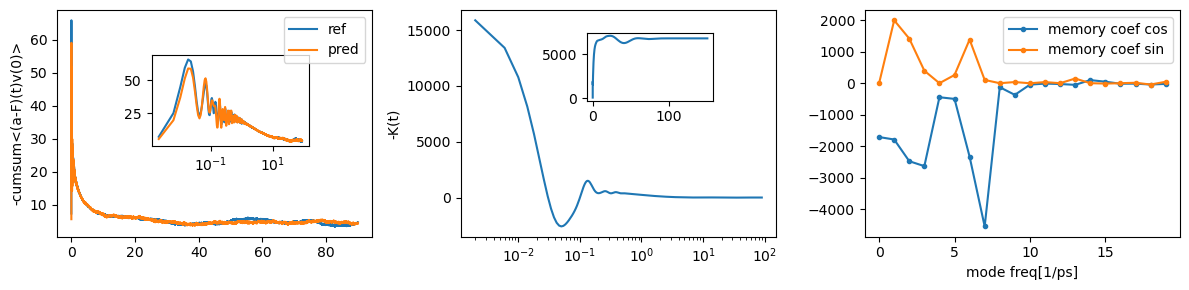

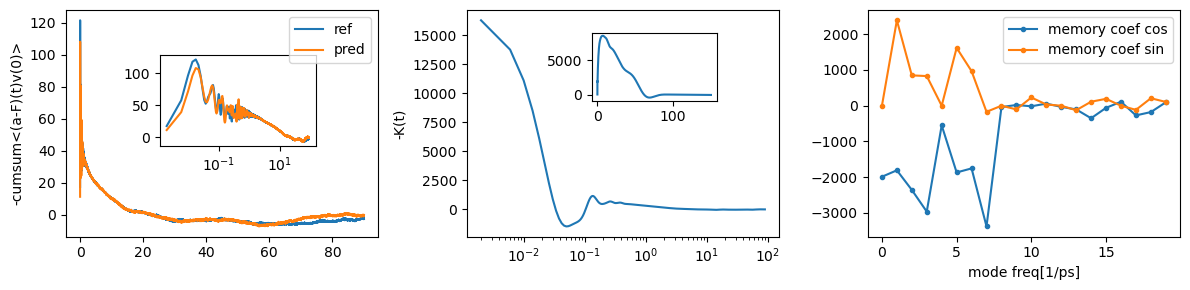

In [9]:
taus = th.tensor([ 0.01, 0.1, 1, 10, 100   ], dtype=th.float, requires_grad=True, device=dev)
aigle = AIGLE(dt, ndim, temp, v2avg, taus).to(device=dev)

import json
with open('alanine_depeptide/GLE_data/cv_fitdr2_fit50ps.json') as f:
    config = json.load(f)
nfreq = int(np.array(config['taus']).size / taus.shape[0])
aigle.nfreq = nfreq
aigle.nmodes = aigle.ntaus * nfreq
aigle.log_taus.data = th.log(np2th(np.array(config['taus'])[::nfreq]))
mem_coef = np2th(np.array(config['mem_coef']))
noise_coef = np2th(np.array(config['noise_coef']))
aigle.mem_coef_cos = mem_coef[:,:aigle.nmodes]
aigle.mem_coef_sin = mem_coef[:,aigle.nmodes:]
aigle.noise_coef_cos.data = noise_coef[:,:aigle.nmodes]
aigle.noise_coef_sin.data = noise_coef[:,aigle.nmodes:]

###
nk = int(2/dt)
fit_t = np2th(dt*(np.arange(nk)+0.5))
qv_cumsum = th.cumsum( (corr_qtv0[1:]+corr_qtv0[:-1])/2, 0) * dt
vv_cumsum = th.cumsum( (corr_vtv0[1:]+corr_vtv0[:-1])/2, 0) * dt
vv_cumsum = th.cat([th.zeros_like(vv_cumsum[0]).reshape(1,2), vv_cumsum], 0)
vv_cumsum_halfgrid = (vv_cumsum[1:]+vv_cumsum[:-1])/2
fit_b = qv_cumsum[:nk]
mat_cvv = np2th(np.zeros((nk, nk, ndim)))
for idx in range(ndim):
    for ii in range(mat_cvv.shape[0]):
        mat_cvv[ii, :ii+1, idx] = th.flip(vv_cumsum_halfgrid[ :ii+1, idx ], [0])
fit_A = mat_cvv * dt
 

### plot  results
nk_long = int(90/dt)
ref_mem_kernel_tgrid = np2th(dt*(np.arange(nk_long)+0.5))
pred_mem_kernel = aigle.get_mem_kernel(ref_mem_kernel_tgrid)
mat_cvv = np2th(np.zeros((nk_long, nk_long, ndim)))
for idx in range(ndim):
    for ii in range(mat_cvv.shape[0]):
        mat_cvv[ii, :ii+1, idx] = th.flip(vv_cumsum_halfgrid[ :ii+1, idx ], [0])
fit_A = mat_cvv * dt
fit_b = qv_cumsum[:nk_long]
tgrid_long = np2th(0.0005*(np.arange(300000)+0.5))
pred_mem_kernel_long = aigle.get_mem_kernel(tgrid_long)

for idx in range(ndim):
    #### plot predicted memory kernel versus reference memory kernel
    fig, ax = plt.subplots(1,3, figsize=(12,3))
    
    pred_b = fit_A[:,:,idx]@pred_mem_kernel[idx]
    ax[0].plot(th2np(ref_mem_kernel_tgrid), -th2np(fit_b[:, idx]), label='ref')
    ax[0].plot(th2np(ref_mem_kernel_tgrid), -th2np(pred_b), label='pred')
    ax[0].legend()
    ax[0].set_ylabel('-cumsum<(a-F)(t)v(0)>')
    axins = ax[0].inset_axes([0.3, 0.4, 0.5, 0.4])
    axins.semilogx(th2np(ref_mem_kernel_tgrid ) , -th2np(fit_b[:,idx])  )
    axins.semilogx(th2np(ref_mem_kernel_tgrid ) , -th2np(pred_b)  )
        
    ax[1].semilogx(th2np(ref_mem_kernel_tgrid), -th2np(pred_mem_kernel[idx]) )
    ax[1].set_ylabel(r'$-K(t)$')
    ax[1].set_xlabel(r'$t$ [ps]')
    # ax[1].set_ylim(-100,500)
    axins = ax[1].inset_axes([0.4, 0.6, 0.4, 0.3])
    axins.plot(th2np(tgrid_long ), -dt*np.cumsum(th2np(pred_mem_kernel_long[idx])) )


    ax[2].plot( th2np(aigle.mem_coef_cos[idx]), label='memory coef cos', marker='o', markersize=3)
    ax[2].plot( th2np(aigle.mem_coef_sin[idx]), label='memory coef sin', marker='o', markersize=3)
    ax[2].legend()
    ax[2].set_xlabel('mode freq[1/ps]')
    plt.tight_layout()
    


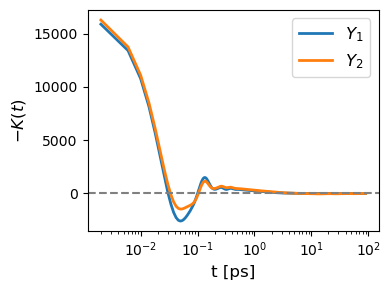

In [23]:
## for presentation
fig, ax = plt.subplots(1,1, figsize=(4,3))
#### plot predicted memory kernel versus reference memory kernel
ax.semilogx(th2np(ref_mem_kernel_tgrid), -th2np(pred_mem_kernel[0]), label=r'$Y_{}$'.format(1), linewidth=2 )
ax.semilogx(th2np(ref_mem_kernel_tgrid), -th2np(pred_mem_kernel[1]), label=r'$Y_{}$'.format(2), linewidth=2 )

ax.set_ylabel(r'$-K(t)$',fontsize=12)
ax.set_xlabel('t [ps]',fontsize=12)
ax.axhline(0,color='grey', linestyle='dashed')
ax.legend(fontsize=12)
plt.tight_layout()
plt.savefig('figures/AD_Kt.png',dpi=200)    

### fit only selected points

iter=0, loss=2163.658935546875 tau=[1.0003849e-02 1.0030401e-01 1.0085288e+00 1.0098050e+01 5.0493683e+01]
iter=500, loss=190.9901580810547 tau=[ 0.19647011  0.25532284  1.0882881   8.03807    34.91936   ]
iter=1000, loss=98.49807739257812 tau=[ 0.14630125  0.15760788  1.3379798   9.909882   36.516388  ]
iter=1500, loss=70.04345703125 tau=[ 0.1264848   0.13410965  1.470717   10.807559   37.271587  ]
iter=2000, loss=59.84331130981445 tau=[ 0.10826061  0.13080303  1.411836   11.134353   37.404377  ]
iter=2500, loss=52.11491394042969 tau=[ 0.09141376  0.12855877  1.3651726  11.46603    37.370506  ]
iter=3000, loss=44.224369049072266 tau=[ 0.07671343  0.12588063  1.3429587  11.79513    37.415375  ]
iter=3500, loss=40.80619430541992 tau=[ 0.07306873  0.12510325  1.3385464  12.0168085  37.535656  ]
iter=4000, loss=38.38689041137695 tau=[ 0.07146591  0.12643766  1.3243371  12.210809   37.595566  ]
iter=4500, loss=36.25299835205078 tau=[ 0.07064745  0.12820973  1.3027416  12.404198   37.70854 

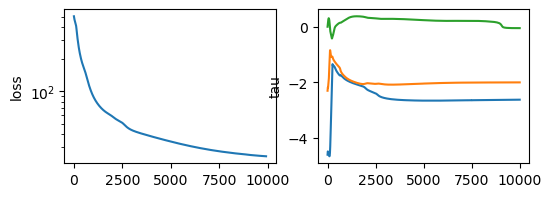

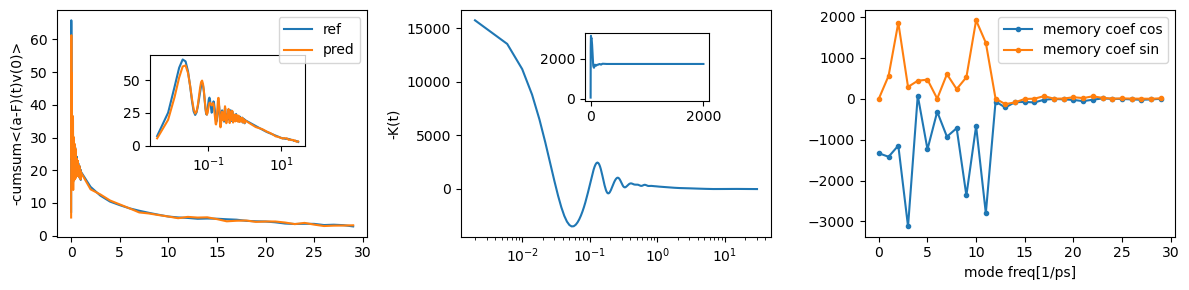

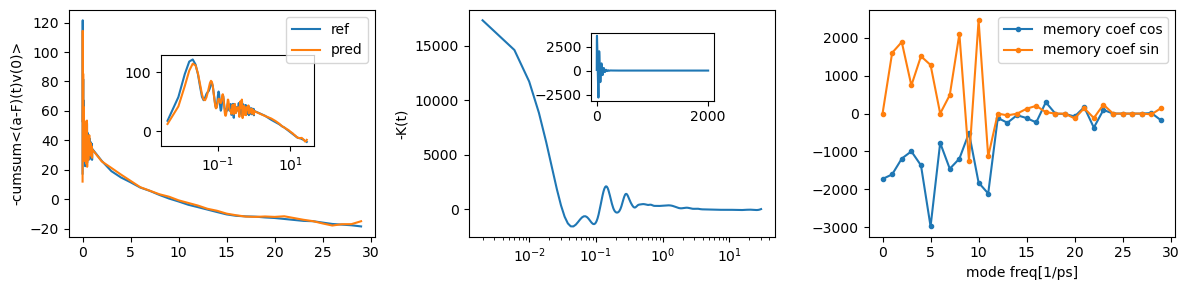

In [40]:
qv_cumsum = th.cumsum( (corr_qtv0[1:]+corr_qtv0[:-1])/2, 0) * dt
vv_cumsum = th.cumsum( (corr_vtv0[1:]+corr_vtv0[:-1])/2, 0) * dt
vv_cumsum = th.cat([th.zeros_like(vv_cumsum[0]).reshape(1,2), vv_cumsum], 0)
vv_cumsum_halfgrid = (vv_cumsum[1:]+vv_cumsum[:-1])/2
####
nk = int(30/dt) #ncorr-2
sample_points = np.concatenate([
    np.arange(int(1/dt)),
    np.arange(int(1/dt), nk, int( 1/dt)),
    # np.arange(1,int(nk*dt))*int(1/dt),
])
nsample = sample_points.size
sample_filter = np2th(np.zeros(nk)).to(dtype=bool)
# sample_weight = sample_points[1:] - sample_points[:-1]
# sample_weight = np2th( np.concatenate([np.ones(1), sample_weight]))
for _ss in sample_points:
    sample_filter[_ss] = True
tgrid = np2th(dt*(np.arange(nk)+0.5))
##
fit_t = tgrid[sample_filter]+0.5*dt
fit_b = qv_cumsum[:nk][sample_filter]
mat_cvv = np2th(np.zeros((nsample, nk, ndim)))
for idx in range(ndim):
    for ii in range(mat_cvv.shape[0]):
        ii_original = sample_points[ii]
        mat_cvv[ii, :ii_original+1, idx] = th.flip(vv_cumsum_halfgrid[ :ii_original+1, idx ], [0])
 
 
### initialize GLE fitting
niter = 10000
nfreq = 6
taus = th.tensor([ 0.01, 0.1, 1, 10, 50   ], dtype=th.float, requires_grad=True, device=dev)

aigle = AIGLE(dt, ndim, temp, v2avg, taus, nfreq=nfreq).to(device=dev)
aigle.init_optimizer(lr_coef=0.4, lr_tau=0.01, gamma=0.99)
optimizer = aigle.optimizer
lossfn = th.nn.MSELoss(reduction='mean')
loss_curve = []
logtau_curve = []
for ii in range(niter):
    mem_coef_cos, mem_coef_sin, mem_kernel, mem_kernel_cumsum = aigle._compute_kernel_from_2FDT(tgrid, tgrid+0.5*dt)
    loss = 0
    for idx in range(ndim):
        ref_b = fit_b[:, idx]
        pred_b = mat_cvv[:,:,idx]@mem_kernel[idx] * dt
        # loss += lossfn(ref_b[250:], pred_b[250:])
        # loss += lossfn(ref_b[:100], pred_b[:100])
        loss += lossfn(ref_b, pred_b) 
        # loss += ((ref_b - pred_b)**2*sample_weight).sum() / sample_weight.sum()
        # loss += th.abs(ref_b - pred_b).sum() * dt
        
    ## backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    aigle.scheduler.step()
    ## bookkeeping
    loss_curve.append(th2np(loss))
    logtau_curve.append(th2np(aigle.log_taus).copy())
    aigle.mem_coef_cos = mem_coef_cos.detach().clone()
    aigle.mem_coef_sin = mem_coef_sin.detach().clone()    
    ## logging
    if ii % int(niter//20) ==0:
        print('iter={}, loss={} tau={}'.format(ii, th2np(loss), th2np(th.exp(aigle.log_taus))))
loss_curve=np.array(loss_curve)
logtau_curve=np.array(logtau_curve)
# aigle.save('fip35/GLE_data/cv_tau4.json')
aigle.save('alanine_depeptide/GLE_data/cv_fitdr2.json')

#### plot loss curve
fig, ax = plt.subplots(1,2, figsize=(6,2))
ax[0].semilogy(loss_curve[100:])
ax[0].set_ylabel('loss')
ax[1].plot(logtau_curve[:,0])
ax[1].plot(logtau_curve[:,1])
ax[1].plot(logtau_curve[:,2])
ax[1].set_ylabel('tau')

### plot  results
ref_mem_kernel_tgrid = tgrid
pred_mem_kernel = aigle.get_mem_kernel(ref_mem_kernel_tgrid)
tgrid_long = np2th(0.001*(np.arange(2000000)+0.5))
pred_mem_kernel_long = aigle.get_mem_kernel(tgrid_long)
 
for idx in range(ndim):
    #### plot predicted memory kernel versus reference memory kernel
    fig, ax = plt.subplots(1,3, figsize=(12,3))
    
    pred_b = mat_cvv[:,:,idx]@pred_mem_kernel[idx] * dt
    ax[0].plot(th2np(fit_t), -th2np(fit_b[:, idx]), label='ref')
    ax[0].plot(th2np(fit_t), -th2np(pred_b), label='pred')
    ax[0].legend()
    ax[0].set_ylabel('-cumsum<(a-F)(t)v(0)>')
    axins = ax[0].inset_axes([0.3, 0.4, 0.5, 0.4])
    axins.semilogx(th2np(fit_t ) , -th2np(fit_b[:,idx])  )
    axins.semilogx(th2np(fit_t ) , -th2np(pred_b)  )
        
    ax[1].semilogx(th2np(ref_mem_kernel_tgrid), -th2np(pred_mem_kernel[idx]) )
    ax[1].set_ylabel('-K(t)')
    axins = ax[1].inset_axes([0.4, 0.6, 0.4, 0.3])
    axins.plot(th2np(tgrid_long ), -dt*np.cumsum(th2np(pred_mem_kernel_long[idx])) )


    ax[2].plot( th2np(aigle.mem_coef_cos[idx]), label='memory coef cos', marker='o', markersize=3)
    ax[2].plot( th2np(aigle.mem_coef_sin[idx]), label='memory coef sin', marker='o', markersize=3)
    ax[2].legend()
    ax[2].set_xlabel('mode freq[1/ps]')
    plt.tight_layout()

### fitting $\int\int$ <q(t)v(0)>dt=$\int\int\int$ K(s)<v(t)v(0)>ds dt

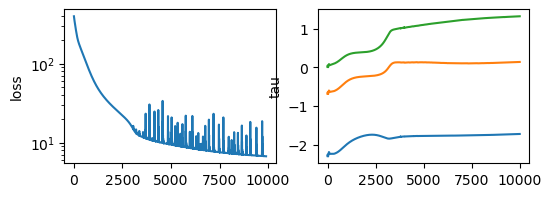

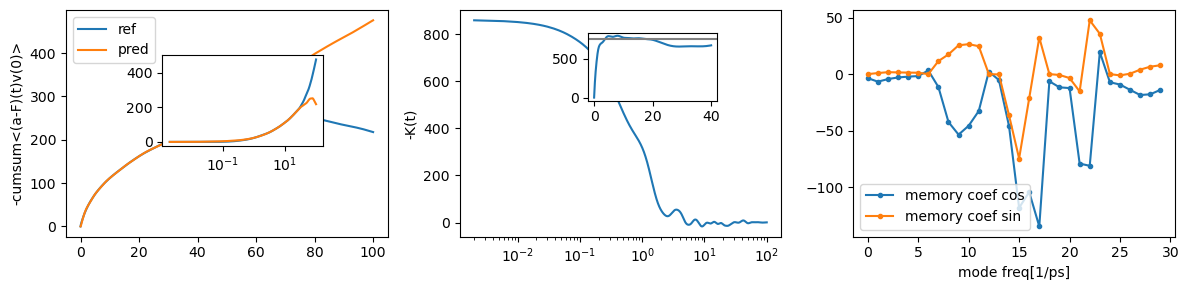

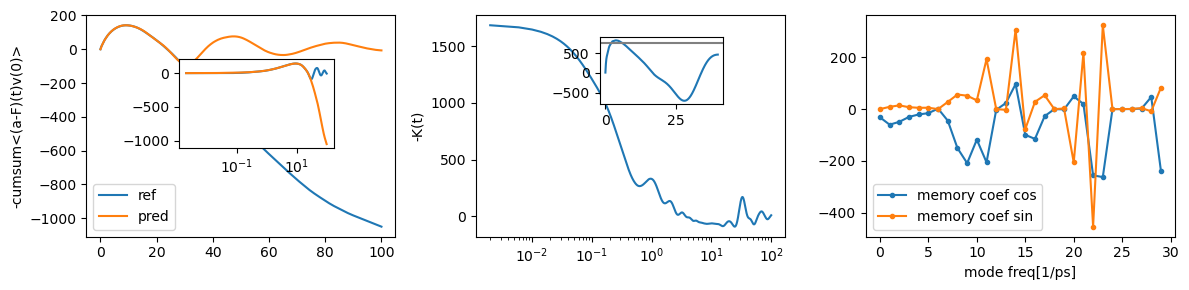

In [79]:
nk = int(100/dt) #ncorr-2
fit_t = np2th(dt*(np.arange(nk)+0.5))
int2_vtv0_halfgrid = (int2_vtv0[1:]+int2_vtv0[:-1])/2
fit_b = int2_qtv0[1:nk+1]
mat_cvv = np2th(np.zeros((nk, nk, ndim)))
for idx in range(ndim):
    for ii in range(mat_cvv.shape[0]):
        mat_cvv[ii, :ii+1, idx] = th.flip(int2_vtv0_halfgrid[ :ii+1, idx ], [0])
fit_A = mat_cvv * dt
 
### initialize GLE fitting
niter = 10000
taus = th.tensor([   0.1, 0.5, 1, 10, 50,   ], dtype=th.float, requires_grad=True, device=dev)
aigle = AIGLE(dt, ndim, temp, v2avg, taus, nfreq=8).to(device=dev)
aigle.init_optimizer(lr_coef=0.4, lr_tau=0.01, gamma=0.99)
optimizer = aigle.optimizer
lossfn = th.nn.MSELoss(reduction='mean')
loss_curve = []
logtau_curve = []
for ii in range(niter):
    mem_coef_cos, mem_coef_sin, mem_kernel, mem_kernel_cumsum = aigle._compute_kernel_from_2FDT(fit_t, fit_t+0.5*dt)
    loss = 0
    for idx in range(ndim):
        ref_b = fit_b[:, idx]
        pred_b = fit_A[:,:,idx]@mem_kernel[idx]
        # loss += lossfn(ref_b[250:], pred_b[250:])
        # loss += lossfn(ref_b[:250], pred_b[:250])
        loss += lossfn(ref_b, pred_b)
        # loss += th.abs(ref_b - pred_b).sum() * dt
        
    ## backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    aigle.scheduler.step()
    ## bookkeeping
    loss_curve.append(th2np(loss))
    logtau_curve.append(th2np(aigle.log_taus).copy())
    aigle.mem_coef_cos = mem_coef_cos.detach().clone()
    aigle.mem_coef_sin = mem_coef_sin.detach().clone()    
    ## logging
    if ii % int(niter//20) ==0:
        print('iter={}, loss={} tau={}'.format(ii, th2np(loss), th2np(th.exp(aigle.log_taus))))
loss_curve=np.array(loss_curve)
logtau_curve=np.array(logtau_curve)
aigle.save('alanine_depeptide/GLE_data/cv_fitr2.json')

#### plot loss curve
fig, ax = plt.subplots(1,2, figsize=(6,2))
ax[0].semilogy(loss_curve[100:])
ax[0].set_ylabel('loss')
ax[1].plot(logtau_curve[:,0])
ax[1].plot(logtau_curve[:,1])
ax[1].plot(logtau_curve[:,2])
ax[1].set_ylabel('tau')


### plot  results
nk_long = int(100/dt)
ref_mem_kernel_tgrid = np2th(dt*(np.arange(nk_long)+0.5))
pred_mem_kernel = aigle.get_mem_kernel(ref_mem_kernel_tgrid)
fit_b = int2_qtv0[1:nk_long+1]
mat_cvv = np2th(np.zeros((nk_long, nk_long, ndim)))
for idx in range(ndim):
    for ii in range(mat_cvv.shape[0]):
        mat_cvv[ii, :ii+1, idx] = th.flip(int2_vtv0_halfgrid[ :ii+1, idx ], [0])
fit_A = mat_cvv * dt


tgrid_long = np2th(dt*(np.arange(10000)+0.5))
pred_mem_kernel_long = aigle.get_mem_kernel(tgrid_long)
## plot the results
for idx in range(ndim):
    #### plot predicted memory kernel versus reference memory kernel
    fig, ax = plt.subplots(1,3, figsize=(12,3))
    
    pred_b = fit_A[:,:,idx]@pred_mem_kernel[idx]
    ax[0].plot(th2np(ref_mem_kernel_tgrid), -th2np(fit_b[:, idx]), label='ref')
    ax[0].plot(th2np(ref_mem_kernel_tgrid), -th2np(pred_b), label='pred')
    ax[0].legend()
    ax[0].set_ylabel('-cumsum<(a-F)(t)v(0)>')
    axins = ax[0].inset_axes([0.3, 0.4, 0.5, 0.4])
    axins.semilogx(th2np(ref_mem_kernel_tgrid ) , -th2np(pred_b)  )
    axins.semilogx(th2np(ref_mem_kernel_tgrid ) , -th2np(fit_b[:,idx])  )
        
    ax[1].semilogx(th2np(ref_mem_kernel_tgrid), -th2np(pred_mem_kernel[idx]) )
    ax[1].set_ylabel('-K(t)')
    
    axins = ax[1].inset_axes([0.4, 0.6, 0.4, 0.3])
    axins.plot(th2np(tgrid_long ), -dt*np.cumsum(th2np(pred_mem_kernel_long[idx])) )
    axins.axhline(750, color = 'grey')


    ax[2].plot( th2np(aigle.mem_coef_cos[idx]), label='memory coef cos', marker='o', markersize=3)
    ax[2].plot( th2np(aigle.mem_coef_sin[idx]), label='memory coef sin', marker='o', markersize=3)
    ax[2].legend()
    ax[2].set_xlabel('mode freq[1/ps]')
    plt.tight_layout()